In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 90
        self.filters = 64
        self.joint_ind = np.array([0,1,2,5,6,9,10,13,14,17,18,21])
        self.data_dir = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/SHREC/'
C = Config()

In [4]:
from scipy.spatial.distance import cdist
def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,0,C.joint_n+1)
    for f in range(C.frame_l):
        #distance max 
        d_m = cdist(p[f],np.concatenate([p[f],np.zeros([1,C.joint_d])]),'euclidean')       
        d_m = d_m[iu] 
        M.append(d_m)
    M = np.stack(M)   
    return M

# Building the model

In [16]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,:1,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x

def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=12,joint_d=3,feat_d=90,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = block(M,filters)
    x = MaxPool1D(2)(x)
    
    x_d_slow = block(diff_slow,filters)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    
    x_d_fast = block(diff_fast,filters)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.2)(x)
    
    x = block(x,filters*8)
    x = SpatialDropout1D(0.2)(x)
    
    return Model(inputs=[M,P],outputs=x)


In [17]:
def build_AR_single(frame_l=32,joint_n=22,joint_d=3,feat_d=90,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [18]:
AR_single = build_AR_single(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_fine,C.filters)

In [8]:
AR_single.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 90)       0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 12, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1674112     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]                    
__________

In [75]:
AR_single.load_weights('weights/fine_heavy.h5')

## load data

In [9]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [10]:
def normlize_range(p):
    # normolize to start point, use the center for hand case
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p

## Without frame_sampling train

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Train['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  1%|          | 19/1960 [00:00<00:10, 184.08it/s]/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 1960/1960 [00:05<00:00, 342.41it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Test['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

  5%|▍         | 41/840 [00:00<00:01, 403.83it/s]/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 840/840 [00:02<00:00, 388.02it/s]


In [19]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=2e-5)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=400,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 1960 samples, validate on 840 samples
Epoch 1/400
1960/1960 [==============================] - 3s 2ms/step - loss: 4.0768 - acc: 0.0398 - val_loss: 2.8681 - val_acc: 0.1821
Epoch 2/400
1960/1960 [==============================] - 0s 63us/step - loss: 3.4845 - acc: 0.0980 - val_loss: 2.5010 - val_acc: 0.3310
Epoch 3/400
1960/1960 [==============================] - 0s 63us/step - loss: 3.1503 - acc: 0.1276 - val_loss: 2.1860 - val_acc: 0.4131
Epoch 4/400
1960/1960 [==============================] - 0s 66us/step - loss: 2.8775 - acc: 0.1959 - val_loss: 1.9972 - val_acc: 0.4417
Epoch 5/400
1960/1960 [==============================] - 0s 70us/step - loss: 2.6821 - acc: 0.2332 - val_loss: 1.8961 - val_acc: 0.4560
Epoch 6/400
1960/1960 [==============================] - 0s 62us/step - loss: 2.5390 - acc: 0.2704 - val_loss: 1.7847 - val_acc: 0.4869
Epoch 7/400
1960/1960 [==============================] - 0s 61us/step - loss: 2.4331 - acc: 0.3015 - val_loss: 1.7103 - val_acc: 0.5036
Ep

Epoch 61/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.2599 - acc: 0.9684 - val_loss: 0.6133 - val_acc: 0.8298
Epoch 62/400
1960/1960 [==============================] - 0s 67us/step - loss: 0.2513 - acc: 0.9719 - val_loss: 0.5844 - val_acc: 0.8405
Epoch 63/400
1960/1960 [==============================] - 0s 69us/step - loss: 0.2524 - acc: 0.9714 - val_loss: 0.5742 - val_acc: 0.8524
Epoch 64/400
1960/1960 [==============================] - 0s 69us/step - loss: 0.2415 - acc: 0.9735 - val_loss: 0.5925 - val_acc: 0.8464
Epoch 65/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.2353 - acc: 0.9765 - val_loss: 0.6149 - val_acc: 0.8357
Epoch 66/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.2230 - acc: 0.9801 - val_loss: 0.6308 - val_acc: 0.8310
Epoch 67/400
1960/1960 [==============================] - 0s 69us/step - loss: 0.2132 - acc: 0.9796 - val_loss: 0.6345 - val_acc: 0.8333
Epoch 68/400
1960/1960 [=================

Epoch 121/400
1960/1960 [==============================] - 0s 66us/step - loss: 0.0690 - acc: 0.9964 - val_loss: 0.6605 - val_acc: 0.8310
Epoch 122/400
1960/1960 [==============================] - 0s 66us/step - loss: 0.0652 - acc: 0.9954 - val_loss: 0.6393 - val_acc: 0.8405
Epoch 123/400
1960/1960 [==============================] - 0s 73us/step - loss: 0.0733 - acc: 0.9980 - val_loss: 0.5964 - val_acc: 0.8548
Epoch 124/400
1960/1960 [==============================] - 0s 74us/step - loss: 0.0697 - acc: 0.9959 - val_loss: 0.5726 - val_acc: 0.8548
Epoch 125/400
1960/1960 [==============================] - 0s 74us/step - loss: 0.0638 - acc: 0.9969 - val_loss: 0.5709 - val_acc: 0.8595
Epoch 126/400
1960/1960 [==============================] - 0s 75us/step - loss: 0.0617 - acc: 0.9969 - val_loss: 0.5776 - val_acc: 0.8560
Epoch 127/400
1960/1960 [==============================] - 0s 75us/step - loss: 0.0653 - acc: 0.9980 - val_loss: 0.5615 - val_acc: 0.8583
Epoch 128/400
1960/1960 [=========

Epoch 181/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0355 - acc: 0.9995 - val_loss: 0.4801 - val_acc: 0.8917
Epoch 182/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0407 - acc: 0.9985 - val_loss: 0.4813 - val_acc: 0.8929
Epoch 183/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0356 - acc: 1.0000 - val_loss: 0.4775 - val_acc: 0.8929
Epoch 184/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0327 - acc: 0.9985 - val_loss: 0.4651 - val_acc: 0.8976
Epoch 185/400
1960/1960 [==============================] - 0s 67us/step - loss: 0.0334 - acc: 0.9995 - val_loss: 0.4600 - val_acc: 0.8988
Epoch 186/400
1960/1960 [==============================] - 0s 65us/step - loss: 0.0343 - acc: 0.9995 - val_loss: 0.4547 - val_acc: 0.8976
Epoch 187/400
1960/1960 [==============================] - 0s 62us/step - loss: 0.0382 - acc: 0.9980 - val_loss: 0.4552 - val_acc: 0.9000
Epoch 188/400
1960/1960 [=========

Epoch 241/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0316 - acc: 1.0000 - val_loss: 0.4343 - val_acc: 0.9048
Epoch 242/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0328 - acc: 0.9995 - val_loss: 0.4345 - val_acc: 0.9048
Epoch 243/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0308 - acc: 0.9995 - val_loss: 0.4346 - val_acc: 0.9048
Epoch 244/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0313 - acc: 0.9990 - val_loss: 0.4346 - val_acc: 0.9048
Epoch 245/400
1960/1960 [==============================] - 0s 71us/step - loss: 0.0323 - acc: 0.9985 - val_loss: 0.4346 - val_acc: 0.9048
Epoch 246/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0318 - acc: 0.9990 - val_loss: 0.4347 - val_acc: 0.9048
Epoch 247/400
1960/1960 [==============================] - 0s 69us/step - loss: 0.0326 - acc: 0.9990 - val_loss: 0.4348 - val_acc: 0.9048
Epoch 248/400
1960/1960 [=========

Epoch 301/400
1960/1960 [==============================] - 0s 62us/step - loss: 0.0333 - acc: 0.9995 - val_loss: 0.4381 - val_acc: 0.9060
Epoch 302/400
1960/1960 [==============================] - 0s 64us/step - loss: 0.0292 - acc: 1.0000 - val_loss: 0.4380 - val_acc: 0.9060
Epoch 303/400
1960/1960 [==============================] - 0s 71us/step - loss: 0.0328 - acc: 0.9990 - val_loss: 0.4377 - val_acc: 0.9060
Epoch 304/400
1960/1960 [==============================] - 0s 69us/step - loss: 0.0306 - acc: 1.0000 - val_loss: 0.4376 - val_acc: 0.9060
Epoch 305/400
1960/1960 [==============================] - 0s 71us/step - loss: 0.0337 - acc: 0.9985 - val_loss: 0.4374 - val_acc: 0.9060
Epoch 306/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0317 - acc: 0.9995 - val_loss: 0.4371 - val_acc: 0.9060
Epoch 307/400
1960/1960 [==============================] - 0s 69us/step - loss: 0.0379 - acc: 0.9969 - val_loss: 0.4370 - val_acc: 0.9060
Epoch 308/400
1960/1960 [=========

Epoch 361/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0315 - acc: 0.9995 - val_loss: 0.4374 - val_acc: 0.9083
Epoch 362/400
1960/1960 [==============================] - 0s 70us/step - loss: 0.0300 - acc: 0.9995 - val_loss: 0.4375 - val_acc: 0.9083
Epoch 363/400
1960/1960 [==============================] - 0s 68us/step - loss: 0.0316 - acc: 0.9995 - val_loss: 0.4375 - val_acc: 0.9083
Epoch 364/400
1960/1960 [==============================] - 0s 65us/step - loss: 0.0337 - acc: 0.9985 - val_loss: 0.4377 - val_acc: 0.9083
Epoch 365/400
1960/1960 [==============================] - 0s 71us/step - loss: 0.0332 - acc: 0.9985 - val_loss: 0.4378 - val_acc: 0.9083
Epoch 366/400
1960/1960 [==============================] - 0s 69us/step - loss: 0.0309 - acc: 1.0000 - val_loss: 0.4378 - val_acc: 0.9083
Epoch 367/400
1960/1960 [==============================] - 0s 71us/step - loss: 0.0279 - acc: 1.0000 - val_loss: 0.4379 - val_acc: 0.9083
Epoch 368/400
1960/1960 [=========

In [20]:
AR_single.save_weights('weights/fine_heavy.h5')

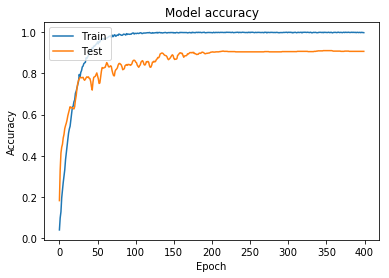

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## With frame_sampling

In [25]:
def sampling_frame(p,C):
    full_l = p.shape[0] # full length
    if random.uniform(0,1)<0.5: # aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        s = random.randint(0, full_l-int(valid_l))
        e = s+valid_l # sample end point
        p = p[int(s):int(e),:,:]    
    else: # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        index = np.sort(np.random.choice(range(0,full_l),int(valid_l),replace=False))
        p = p[index,:,:]
    p = zoom(p,C.frame_l,C.joint_n,C.joint_d)
    return p

In [26]:
lr = 2e-5
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [27]:
epochs = 50
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    #for i in range(len(Train['pose'])): 
    
        label = np.zeros(C.clc_fine)
        label[Train['fine_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
        p = sampling_frame(p,C)
        
        #rotation
        x_angle = np.random.uniform(-0.2,0.2)
        y_angle = np.random.uniform(-0.2,0.2)
        z_angle = np.random.uniform(-0.2,0.2)
        R = euler2mat(x_angle, y_angle, z_angle, 'sxyz')
        p = rotaion_one(p,R)
        
        p = normlize_range(p)
        
        p[:,:,0] = p[:,:,0]*random.uniform(0.9, 1.1)+p[:,:,0]*random.uniform(-0.1,0.1)
        p[:,:,1] = p[:,:,1]*random.uniform(0.9, 1.1)+p[:,:,1]*random.uniform(-0.1,0.1)
        p[:,:,2] = p[:,:,2]*random.uniform(0.9, 1.1)+p[:,:,2]*random.uniform(-0.1,0.1)
        
        
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    AR_single.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

    if e%10==0:
        AR_single.save_weights('weights/fine_heavy.h5')


  1%|          | 23/1960 [00:00<00:08, 224.70it/s]

epoch0


/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 1960/1960 [00:05<00:00, 373.46it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0544 - acc: 0.9934 - val_loss: 0.4370 - val_acc: 0.9060


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch1


100%|██████████| 1960/1960 [00:05<00:00, 377.57it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 67us/step - loss: 0.0660 - acc: 0.9883 - val_loss: 0.4364 - val_acc: 0.9083


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch2


100%|██████████| 1960/1960 [00:05<00:00, 371.96it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 65us/step - loss: 0.0616 - acc: 0.9903 - val_loss: 0.4358 - val_acc: 0.9083


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch3


100%|██████████| 1960/1960 [00:05<00:00, 384.59it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 68us/step - loss: 0.0570 - acc: 0.9918 - val_loss: 0.4359 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch4


100%|██████████| 1960/1960 [00:05<00:00, 361.59it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0616 - acc: 0.9903 - val_loss: 0.4366 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch5


100%|██████████| 1960/1960 [00:05<00:00, 382.57it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0615 - acc: 0.9893 - val_loss: 0.4372 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch6


100%|██████████| 1960/1960 [00:05<00:00, 372.41it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0642 - acc: 0.9908 - val_loss: 0.4378 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch7


100%|██████████| 1960/1960 [00:05<00:00, 384.03it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0619 - acc: 0.9908 - val_loss: 0.4383 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch8


100%|██████████| 1960/1960 [00:05<00:00, 383.15it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0568 - acc: 0.9923 - val_loss: 0.4385 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch9


100%|██████████| 1960/1960 [00:05<00:00, 385.36it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 62us/step - loss: 0.0671 - acc: 0.9898 - val_loss: 0.4387 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch10


100%|██████████| 1960/1960 [00:05<00:00, 372.78it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0539 - acc: 0.9913 - val_loss: 0.4388 - val_acc: 0.9095


  1%|          | 17/1960 [00:00<00:11, 167.84it/s]

epoch11


100%|██████████| 1960/1960 [00:05<00:00, 367.58it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 66us/step - loss: 0.0539 - acc: 0.9939 - val_loss: 0.4393 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch12


100%|██████████| 1960/1960 [00:05<00:00, 371.18it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 63us/step - loss: 0.0534 - acc: 0.9939 - val_loss: 0.4399 - val_acc: 0.9119


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch13


100%|██████████| 1960/1960 [00:05<00:00, 382.61it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 66us/step - loss: 0.0607 - acc: 0.9893 - val_loss: 0.4402 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch14


100%|██████████| 1960/1960 [00:05<00:00, 376.13it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 65us/step - loss: 0.0669 - acc: 0.9893 - val_loss: 0.4409 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch15


100%|██████████| 1960/1960 [00:05<00:00, 372.28it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 63us/step - loss: 0.0641 - acc: 0.9918 - val_loss: 0.4411 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch16


100%|██████████| 1960/1960 [00:05<00:00, 383.03it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 61us/step - loss: 0.0649 - acc: 0.9918 - val_loss: 0.4410 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch17


100%|██████████| 1960/1960 [00:05<00:00, 372.63it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 58us/step - loss: 0.0525 - acc: 0.9939 - val_loss: 0.4414 - val_acc: 0.9083


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch18


100%|██████████| 1960/1960 [00:05<00:00, 365.45it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 61us/step - loss: 0.0689 - acc: 0.9913 - val_loss: 0.4419 - val_acc: 0.9083


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch19


100%|██████████| 1960/1960 [00:05<00:00, 382.36it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 61us/step - loss: 0.0587 - acc: 0.9918 - val_loss: 0.4428 - val_acc: 0.9083


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch20


100%|██████████| 1960/1960 [00:05<00:00, 383.71it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 66us/step - loss: 0.0679 - acc: 0.9893 - val_loss: 0.4436 - val_acc: 0.9071


  1%|          | 17/1960 [00:00<00:11, 166.87it/s]

epoch21


100%|██████████| 1960/1960 [00:05<00:00, 372.03it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 63us/step - loss: 0.0514 - acc: 0.9954 - val_loss: 0.4444 - val_acc: 0.9083


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch22


100%|██████████| 1960/1960 [00:05<00:00, 384.51it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 58us/step - loss: 0.0573 - acc: 0.9929 - val_loss: 0.4448 - val_acc: 0.9083


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch23


100%|██████████| 1960/1960 [00:05<00:00, 385.08it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0653 - acc: 0.9903 - val_loss: 0.4448 - val_acc: 0.9083


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch24


100%|██████████| 1960/1960 [00:05<00:00, 382.71it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 59us/step - loss: 0.0515 - acc: 0.9939 - val_loss: 0.4446 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch25


100%|██████████| 1960/1960 [00:05<00:00, 384.19it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 61us/step - loss: 0.0526 - acc: 0.9944 - val_loss: 0.4446 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch26


100%|██████████| 1960/1960 [00:05<00:00, 371.50it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 59us/step - loss: 0.0533 - acc: 0.9913 - val_loss: 0.4449 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch27


100%|██████████| 1960/1960 [00:05<00:00, 385.59it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 63us/step - loss: 0.0467 - acc: 0.9964 - val_loss: 0.4451 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch28


100%|██████████| 1960/1960 [00:05<00:00, 371.34it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0680 - acc: 0.9918 - val_loss: 0.4452 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch29


100%|██████████| 1960/1960 [00:05<00:00, 383.23it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 65us/step - loss: 0.0572 - acc: 0.9888 - val_loss: 0.4451 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch30


100%|██████████| 1960/1960 [00:05<00:00, 372.70it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 63us/step - loss: 0.0511 - acc: 0.9954 - val_loss: 0.4448 - val_acc: 0.9095


  1%|          | 17/1960 [00:00<00:11, 168.45it/s]

epoch31


100%|██████████| 1960/1960 [00:05<00:00, 370.75it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 62us/step - loss: 0.0505 - acc: 0.9944 - val_loss: 0.4444 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch32


100%|██████████| 1960/1960 [00:05<00:00, 383.93it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 61us/step - loss: 0.0506 - acc: 0.9959 - val_loss: 0.4442 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch33


100%|██████████| 1960/1960 [00:05<00:00, 382.13it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0550 - acc: 0.9939 - val_loss: 0.4441 - val_acc: 0.9095


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch34


100%|██████████| 1960/1960 [00:05<00:00, 382.71it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0640 - acc: 0.9918 - val_loss: 0.4440 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch35


100%|██████████| 1960/1960 [00:05<00:00, 381.88it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0631 - acc: 0.9913 - val_loss: 0.4436 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch36


100%|██████████| 1960/1960 [00:05<00:00, 371.86it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 61us/step - loss: 0.0558 - acc: 0.9913 - val_loss: 0.4433 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch37


100%|██████████| 1960/1960 [00:05<00:00, 383.10it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0637 - acc: 0.9883 - val_loss: 0.4429 - val_acc: 0.9107


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch38


100%|██████████| 1960/1960 [00:05<00:00, 348.00it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 65us/step - loss: 0.0593 - acc: 0.9923 - val_loss: 0.4424 - val_acc: 0.9119


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch39


100%|██████████| 1960/1960 [00:05<00:00, 349.23it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 66us/step - loss: 0.0477 - acc: 0.9959 - val_loss: 0.4423 - val_acc: 0.9119


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch40


100%|██████████| 1960/1960 [00:05<00:00, 371.06it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 61us/step - loss: 0.0546 - acc: 0.9934 - val_loss: 0.4421 - val_acc: 0.9119


  1%|          | 18/1960 [00:00<00:11, 172.62it/s]

epoch41


100%|██████████| 1960/1960 [00:05<00:00, 361.98it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 70us/step - loss: 0.0503 - acc: 0.9949 - val_loss: 0.4423 - val_acc: 0.9119


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch42


100%|██████████| 1960/1960 [00:05<00:00, 361.34it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 62us/step - loss: 0.0561 - acc: 0.9918 - val_loss: 0.4423 - val_acc: 0.9119


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch43


100%|██████████| 1960/1960 [00:05<00:00, 383.42it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 63us/step - loss: 0.0560 - acc: 0.9929 - val_loss: 0.4423 - val_acc: 0.9119


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch44


100%|██████████| 1960/1960 [00:05<00:00, 335.45it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 63us/step - loss: 0.0463 - acc: 0.9964 - val_loss: 0.4422 - val_acc: 0.9119


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch45


100%|██████████| 1960/1960 [00:05<00:00, 385.25it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 60us/step - loss: 0.0505 - acc: 0.9949 - val_loss: 0.4420 - val_acc: 0.9119


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch46


100%|██████████| 1960/1960 [00:05<00:00, 370.50it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 67us/step - loss: 0.0577 - acc: 0.9929 - val_loss: 0.4415 - val_acc: 0.9131


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch47


100%|██████████| 1960/1960 [00:05<00:00, 384.66it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 64us/step - loss: 0.0504 - acc: 0.9934 - val_loss: 0.4415 - val_acc: 0.9131


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch48


100%|██████████| 1960/1960 [00:05<00:00, 383.83it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 59us/step - loss: 0.0536 - acc: 0.9949 - val_loss: 0.4417 - val_acc: 0.9119


  0%|          | 0/1960 [00:00<?, ?it/s]

epoch49


100%|██████████| 1960/1960 [00:05<00:00, 385.27it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 59us/step - loss: 0.0538 - acc: 0.9944 - val_loss: 0.4416 - val_acc: 0.9107


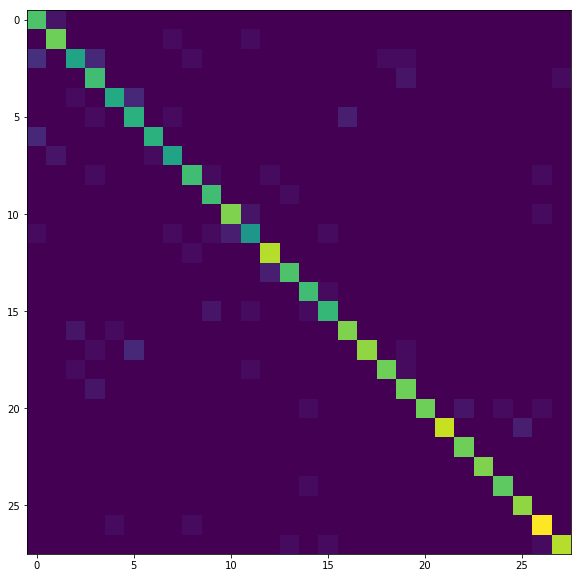

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = AR_single.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()